In [1]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

%matplotlib inline

#Ignore warning
import warnings
warnings.filterwarnings('ignore')

plt.ion()  #interactive mode

In [2]:
#read CSV file and get the annotations in an (N, 2) array where N is the number of landmarks 
landmarks_frame = pd.read_csv('data/faces/face_landmarks.csv')

n = 65
img_name = landmarks_frame.iloc[n, 0]
landmarks = landmarks_frame.iloc[n, 1:].as_matrix()
landmarks = landmarks.astype('float').reshape(-1, 2)

print('Image name: {}'.format(img_name))
print('Landmarks shape: {}'.format(landmarks.shape))
print('First 4 Landmarks:{}'.format(landmarks[:4]))

Image name: person-7.jpg
Landmarks shape: (68, 2)
First 4 Landmarks:[[32. 65.]
 [33. 76.]
 [34. 86.]
 [34. 97.]]


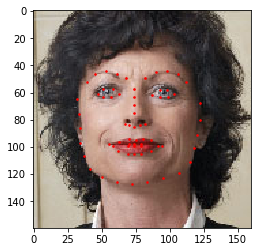

In [3]:
#To show an image and its landmarks 
def show_landmarks(image, landmarks):
    """show image with landmarks"""
    plt.imshow(image)
    plt.scatter(landmarks[: , 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  #pause a bit so that plots are updated
    
plt.figure()
show_landmarks(io.imread(os.path.join('data/faces/', img_name)), landmarks)
plt.show()

In [7]:
#define our dataset
class FaceLandmarksDataset(Dataset):
    """Face landmarks dataset"""
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file(string): Path to the csv file with annotations.
            toot_dir(string):Dirctory with all the images.
            transform(callable, optional):Optional transform to be applied on example
            
        """
        self.landmarks_frame= pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.landmarks_frame)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx,0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix()
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image':image, 'landmarks': landmarks}
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample
    

0 (324, 215, 3) (68, 2)


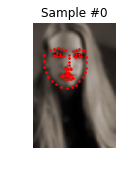

1 (500, 333, 3) (68, 2)


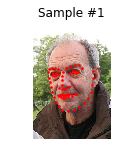

2 (250, 258, 3) (68, 2)


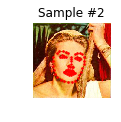

3 (434, 290, 3) (68, 2)


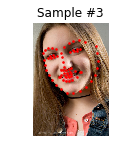

In [10]:
#instantiate this class and iterate through the data samples. 
#We will print the sizes of first 4 samples and show their landmarks.

face_dataset = FaceLandmarksDataset(csv_file="data/faces/face_landmarks.csv", root_dir='data/faces/')

fig = plt.figure()
for i in range(len(face_dataset)):
    sample = face_dataset[i]
    
    print(i, sample['image'].shape, sample['landmarks'].shape)
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_landmarks(**sample)
    
    if i == 3:
        plt.show()
        break
    

In [11]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for landmarks because for images,
        # x and y axes are axis 1 and 0 respectively
        landmarks = landmarks * [new_w / w, new_h / h]

        return {'image': img, 'landmarks': landmarks}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        landmarks = landmarks - [left, top]

        return {'image': image, 'landmarks': landmarks}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, landmarks = sample['image'], sample['landmarks']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'landmarks': torch.from_numpy(landmarks)}

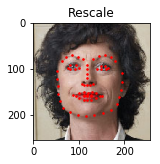

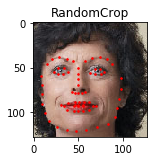

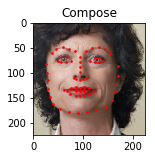

In [12]:
######################################################################
# Compose transforms
# ~~~~~~~~~~~~~~~~~~
#
# Now, we apply the transforms on an sample.
#
# Let's say we want to rescale the shorter side of the image to 256 and
# then randomly crop a square of size 224 from it. i.e, we want to compose
# ``Rescale`` and ``RandomCrop`` transforms.
# ``torchvision.transforms.Compose`` is a simple callable class which allows us
# to do this.
#

scale = Rescale(256)
crop = RandomCrop(128)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = face_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_landmarks(**transformed_sample)

plt.show()

In [13]:
######################################################################
# Iterating through the dataset
# -----------------------------
#
# Let's put this all together to create a dataset with composed
# transforms.
# To summarize, every time this dataset is sampled:
#
# -  An image is read from the file on the fly
# -  Transforms are applied on the read image
# -  Since one of the transforms is random, data is augmentated on
#    sampling
#
# We can iterate over the created dataset with a ``for i in range``
# loop as before.
#

transformed_dataset = FaceLandmarksDataset(csv_file='data/faces/face_landmarks.csv',
                                           root_dir='data/faces/',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([68, 2])
1 torch.Size([3, 224, 224]) torch.Size([68, 2])
2 torch.Size([3, 224, 224]) torch.Size([68, 2])
3 torch.Size([3, 224, 224]) torch.Size([68, 2])


0 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
1 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
2 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])
3 torch.Size([4, 3, 224, 224]) torch.Size([4, 68, 2])


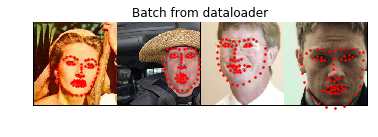

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f2f88c4b710>>
Traceback (most recent call last):
  File "/home/winner/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/winner/.local/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 345, in get
    return ForkingPickler.loads(res)
  File "/home/winner/.local/lib/python3.5/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/usr/lib/python3.5/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/usr/lib/python3.5/multiprocessing/reduction.py", line 181, in recv_handle
    return recvfds(s, 1)[0]
  File "/usr/lib/python3.5/multiprocessing/redu

In [16]:
######################################################################
# However, we are losing a lot of features by using a simple ``for`` loop to
# iterate over the data. In particular, we are missing out on:
#
# -  Batching the data
# -  Shuffling the data
# -  Load the data in parallel using ``multiprocessing`` workers.
#
# ``torch.utils.data.DataLoader`` is an iterator which provides all these
# features. Parameters used below should be clear. One parameter of
# interest is ``collate_fn``. You can specify how exactly the samples need
# to be batched using ``collate_fn``. However, default collate should work
# fine for most use cases.
#

dataloader = DataLoader(transformed_dataset, batch_size=4,
                        shuffle=True, num_workers=4)


# Helper function to show a batch
def show_landmarks_batch(sample_batched):
    """Show image with landmarks for a batch of samples."""
    images_batch, landmarks_batch = \
            sample_batched['image'], sample_batched['landmarks']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(landmarks_batch[i, :, 0].numpy() + i * im_size,
                    landmarks_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['landmarks'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break